EDA, version 2

## CONEXIÓN A BASE DE DATOS TIMES-SERIES

In [ ]:
# PAQUETES IMPORTADOS
import pandas as pd
from sqlalchemy import create_engine

In [13]:
import pandas as pd
from sqlalchemy import create_engine

USER = "postgres"
PASSWORD = "ale2001"
HOST = "localhost"
PORT = "5432"
DBNAME = "bdts"

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}")

# Traer una variable para el primer análisis
query = """
SELECT 
    ts_utc,
    variable,
    valor
FROM raw.ingestas
WHERE variable = 'Acceleration RMS (Radial)' 
ORDER BY ts_utc;
"""

# where variable =  'Acceleration RMS (Radial)' and cast (ts_utc as date) <= '2025-08-21 08:45:00-05'

df = pd.read_sql(query, engine)

print(df.head(5))
print()
print('Estadísticos descriptivos\n')
print(df.describe())

                     ts_utc                   variable   valor
0 2025-08-11 07:40:01+00:00  Acceleration RMS (Radial)  0.1873
1 2025-08-11 07:55:00+00:00  Acceleration RMS (Radial)  0.1898
2 2025-08-11 08:10:01+00:00  Acceleration RMS (Radial)  0.1941
3 2025-08-11 08:25:00+00:00  Acceleration RMS (Radial)  0.1938
4 2025-08-11 08:40:01+00:00  Acceleration RMS (Radial)  0.1830

Estadísticos descriptivos

             valor
count  6233.000000
mean      0.554828
std       0.341143
min       0.005200
25%       0.176600
50%       0.763200
75%       0.849100
max       1.254900


In [2]:
duplicados = df.duplicated(subset=['ts_utc', 'variable']).sum()
print(duplicados)


0


In [3]:
df[df.duplicated(subset=['ts_utc', 'variable'], keep=False)]


,ts_utc,variable,valor


In [10]:
df['ts_utc'] = pd.to_datetime(df['ts_utc'])
df = df.sort_values('ts_utc')

df['delta'] = df['ts_utc'].diff().dt.total_seconds()

gaps = df[df['delta'] > 900]  # más de 15 min
gaps.head(10)


,ts_utc,variable,valor,delta
2,2025-08-11 08:10:01+00:00,Acceleration RMS (Radial),0.1941,901.0
4,2025-08-11 08:40:01+00:00,Acceleration RMS (Radial),0.1830,901.0
6,2025-08-11 09:10:01+00:00,Acceleration RMS (Radial),0.1919,901.0
8,2025-08-11 09:40:01+00:00,Acceleration RMS (Radial),0.1941,901.0
10,2025-08-11 10:10:01+00:00,Acceleration RMS (Radial),0.1946,901.0
12,2025-08-11 10:40:01+00:00,Acceleration RMS (Radial),0.1948,901.0
14,2025-08-11 11:10:01+00:00,Acceleration RMS (Radial),0.1870,901.0
16,2025-08-11 11:40:01+00:00,Acceleration RMS (Radial),0.1781,901.0
18,2025-08-11 12:10:01+00:00,Acceleration RMS (Radial),0.1775,901.0
20,2025-08-11 12:40:01+00:00,Acceleration RMS (Radial),0.1899,901.0


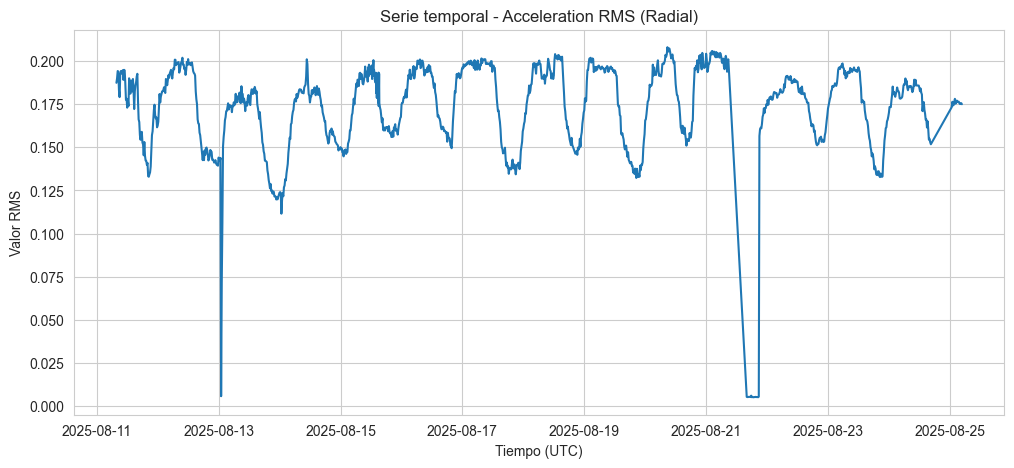

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['ts_utc'], df['valor'])
plt.title("Serie temporal - Acceleration RMS (Radial)")
plt.xlabel("Tiempo (UTC)")
plt.ylabel("Valor RMS")
plt.show()


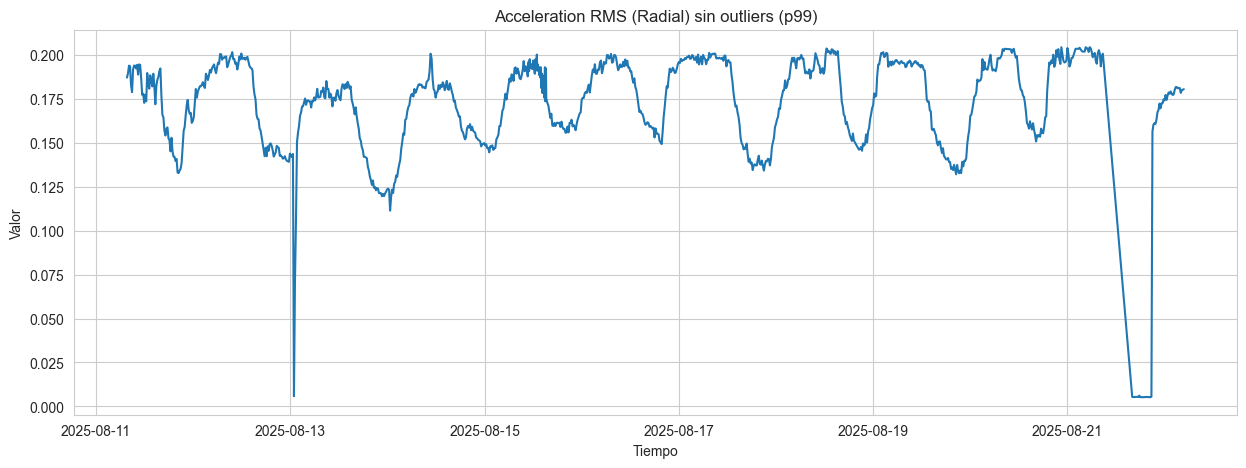

In [116]:
import matplotlib.pyplot as plt

# 1. Calcular el percentil 99 de la variable
p99 = df['valor'].quantile(0.99)

# 2. Filtrar los valores que están por debajo del p99
df_sin_outliers = df[df['valor'] <= p99]

# 3. Graficar la señal sin valores extremos
plt.figure(figsize=(15,5))
plt.plot(df_sin_outliers['ts_utc'], df_sin_outliers['valor'])
plt.title('Acceleration RMS (Radial) sin outliers (p99)')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()


In [121]:
p95 = df['valor'].quantile(0.95)
p99 = df['valor'].quantile(0.99)
print(p95, p99)


0.201 0.2046


In [107]:
p95 = df['valor'].quantile(0.95)
p99 = df['valor'].quantile(0.99)
print()
print('P95 = ', p95, 'P99 = ',p99)
print()
print('Outliers > P99')
df_outliers = df[df['valor'] > p99]
df_outliers.head(5)



P95 =  0.9614 P99 =  1.0293

Outliers > P99


,ts_utc,variable,valor
2689,2025-09-08 22:59:01+00:00,Acceleration RMS (Radial),1.0352
3361,2025-09-17 20:30:01+00:00,Acceleration RMS (Radial),1.0527
3364,2025-09-17 21:15:00+00:00,Acceleration RMS (Radial),1.0303
3458,2025-09-18 20:45:00+00:00,Acceleration RMS (Radial),1.0322
3459,2025-09-18 21:00:01+00:00,Acceleration RMS (Radial),1.0586


In [91]:
df_cat = df[df["variable"]=="Bearing Condition"]
df_cat["valor"].value_counts()


array(['Acceleration RMS (Axial)', 'Acceleration RMS (Radial)',
       'Acceleration RMS (Tangential)', 'Bearing Condition',
       'Looseness (BETA)', 'Misalignment (BETA)',
       'Motor Supply Frequency', 'Output Power', 'Overall Vibration',
       'Peak to Peak', 'Peak to Peak (Axial)', 'Peak to Peak (Radial)',
       'Peak to Peak (Tangential)', 'Skin Temperature', 'Speed',
       'Nr. Of Starts Between Measurements', 'Total Running Time',
       'Total Number Of Starts', 'Unbalance (BETA)', 'Vibration (Axial)',
       'Vibration (Radial)', 'Vibration (Tangential)'], dtype=object)

In [17]:
import pandas as pd

# df = tu dataframe completo de raw.ingestas filtrado por la variable 'valor'
USER = "postgres"
PASSWORD = "ale2001"
HOST = "localhost"
PORT = "5432"
DBNAME = "bdts"

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}")
df = pd.read_sql(query, engine)

# Traer una variable para el primer análisis
query = """
SELECT 
    ts_utc,
    variable,
    valor
FROM raw.ingestas
ORDER BY ts_utc;
"""


tabla = (
    df.groupby("variable")["valor"]
    .agg(
        conteo="count",
        minimo="min",
        maximo="max",
        media="mean",
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p95=lambda x: x.quantile(0.95),
        p99=lambda x: x.quantile(0.99),
    )
)

# Contar outliers > p99 para cada variable
outliers = (
    df.assign(p99=df.groupby("variable")["valor"].transform(lambda x: x.quantile(0.99)))
    .query("valor > p99")
    .groupby("variable")
    .size()
    .rename("outliers_p99")
)

# Unir tablas
tabla_final = tabla.join(outliers, how="left").fillna(0)

tabla_final


,conteo,minimo,maximo,media,p25,p50,p75,p95,p99,outliers_p99
variable,,,,,,,,,,
Acceleration RMS (Axial),6233,0.0049,2.2031,1.221842,0.7056,1.4883,1.6299,1.9043,2.062500,60.0
Acceleration RMS (Radial),6233,0.0052,1.2549,0.554828,0.1766,0.7632,0.8491,0.9614,1.029300,62.0
Acceleration RMS (Tangential),6233,0.0051,2.1484,0.989590,0.5176,1.1855,1.3389,1.6650,1.870100,62.0
Bearing Condition,6172,0.0000,4.0000,2.080201,2.0000,2.0000,3.0000,3.0000,3.000000,1.0
Looseness (BETA),6233,0.0000,1.0000,0.002086,0.0000,0.0000,0.0000,0.0000,0.000000,13.0
Misalignment (BETA),6233,0.0000,1.0000,0.000160,0.0000,0.0000,0.0000,0.0000,0.000000,1.0
Motor Supply Frequency,6233,0.0000,51.5300,43.682777,36.2800,49.5900,50.1200,50.5000,50.590000,60.0
Number of Starts Between Measurements,6273,0.0000,2.0000,0.289495,0.0000,0.0000,1.0000,1.0000,1.000000,5.0
Output Power,6182,0.0000,292.3300,102.077967,91.2725,100.2200,113.1875,139.2795,163.212800,62.0


In [26]:
import pandas as pd

# Filtrar solamente las variables categóricas
categoricas = ["Bearing Condition", "Looseness (BETA)", "Misalignment (BETA)",
               "Unbalance (BETA)",  "Number of Starts Between Measurements", "Total Number Of Starts"]

df_cat = df[df["variable"].isin(categoricas)]

tabla_cat = (
    df_cat.groupby("variable")["valor"]
    .agg(
        conteo="count",
        valores_unicos=lambda x: sorted(x.unique().tolist()),
        valor_mas_frecuente=lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    )
)

tabla_cat["conteo"] = tabla_cat["conteo"].astype(int)
print(tabla_cat)

                                       conteo  \
variable                                        
Bearing Condition                        6172   
Looseness (BETA)                         6233   
Misalignment (BETA)                      6233   
Number of Starts Between Measurements    6273   
Total Number Of Starts                   6273   
Unbalance (BETA)                         6233   

                                                                          valores_unicos  \
variable                                                                                   
Bearing Condition                                              [0.0, 1.0, 2.0, 3.0, 4.0]   
Looseness (BETA)                                                              [0.0, 1.0]   
Misalignment (BETA)                                                           [0.0, 1.0]   
Number of Starts Between Measurements                                    [0.0, 1.0, 2.0]   
Total Number Of Starts                 [87.0, 89.0, 90.

C:\Users\HP\AppData\Local\Temp\ipykernel_4068\2329150341.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="valor", data=data_filtrada, order=data_filtrada["valor"].value_counts().index, palette="viridis")
C:\Users\HP\AppData\Local\Temp\ipykernel_4068\2329150341.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="valor", data=data_filtrada, order=data_filtrada["valor"].value_counts().index, palette="viridis")
C:\Users\HP\AppData\Local\Temp\ipykernel_4068\2329150341.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="valor"

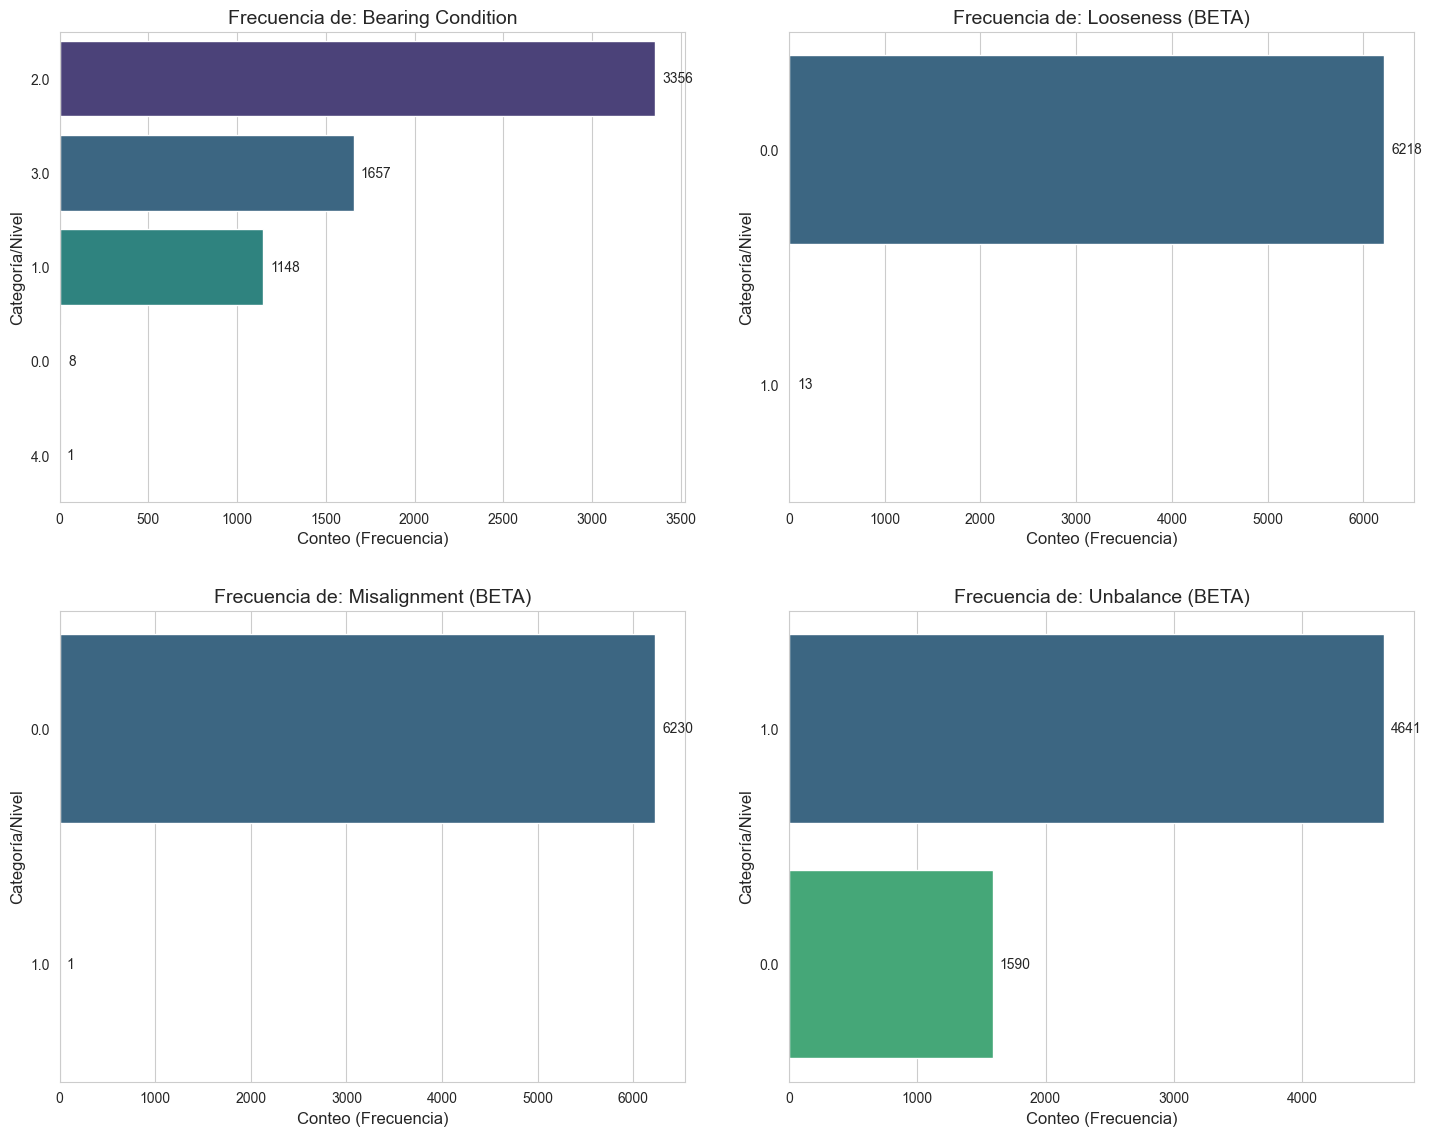

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración básica para los gráficos
sns.set_style("whitegrid")
plt.figure(figsize=(15, 12)) # Ajusta el tamaño de la figura principal

# Iterar sobre cada variable categórica para crear un gráfico
for i, variable in enumerate(categoricas):
    # 1. Crear un subgráfico para cada variable
    plt.subplot(2, 2, i + 1) # Crea una cuadrícula de 2x2
    
    # 2. Filtrar el DataFrame original para la variable actual
    data_filtrada = df_cat[df_cat["variable"] == variable]
    
    # 3. Generar el gráfico de barras
    # Usamos `countplot` de seaborn que calcula la frecuencia y grafica automáticamente
    sns.countplot(y="valor", data=data_filtrada, order=data_filtrada["valor"].value_counts().index, palette="viridis")
    
    # 4. Añadir título y etiquetas
    plt.title(f'Frecuencia de: {variable}', fontsize=14)
    plt.xlabel('Conteo (Frecuencia)', fontsize=12)
    plt.ylabel('Categoría/Nivel', fontsize=12)
    
    # Opcional: Mostrar los valores de conteo en las barras
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                           ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout(pad=3.0) # Ajusta automáticamente los subplots para que no se superpongan
plt.show()